In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [11]:
df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [14]:
 df_spam = df[df['Category']=='spam']
 df_spam.shape

(747, 2)

In [17]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [19]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [22]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [23]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [24]:
df_balanced.sample(10)

,Category,Message
846,ham,Meanwhile in the shit suite: xavier decided to...
2386,spam,Someone has contacted our dating service and e...
3378,ham,Yup. Wun believe wat? U really neva c e msg i ...
5313,ham,My sister going to earn more than me da.
707,ham,So when do you wanna gym harri
1384,ham,Please reserve ticket on saturday eve from che...
2160,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...
3560,spam,URGENT! We are trying to contact U Todays draw...
4438,ham,How come u got nothing to do?
1780,spam,"Loan for any purpose £500 - £75,000. Homeowner..."


In [27]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1634,ham,Yesterday its with me only . Now am going home.,0
1985,spam,Urgent! Please call 09061743810 from landline....,1
228,ham,Hey company elama po mudyadhu.,0
3602,ham,"Jay told me already, will do",0
3560,spam,URGENT! We are trying to contact U Todays draw...,1


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [30]:
X_train.head(5)

1571    No:-)i got rumour that you going to buy apartm...
4300    Hurt me... Tease me... Make me cry... But in t...
1628    You have been selected to stay in 1 of 250 top...
1963    it to 80488. Your 500 free text messages are v...
1019    Nope watching tv at home... Not going out. V b...
Name: Message, dtype: object

In [33]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [34]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

In [38]:
from os import name

# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name="text")

preprocessed_text = bert_preprocess(text_input)

outputs = bert_encoder(preprocessed_text)

#Neural network Layers
l = tf.keras.layers.Dropout(0.1, name ='dropout')(outputs['pooled_output'])

l=tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# final model
model=tf.keras.Model(inputs=[text_input], outputs=[l])

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [42]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [44]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 544s 16s/step - loss: 0.2757 - accuracy: 0.9107 - precision: 0.8993 - recall: 0.9250
Epoch 2/10
35/35 [==============================] - 546s 16s/step - loss: 0.2716 - accuracy: 0.9152 - precision: 0.9016 - recall: 0.9321
Epoch 3/10
35/35 [==============================] - 545s 16s/step - loss: 0.2629 - accuracy: 0.9152 - precision: 0.9029 - recall: 0.9304
Epoch 4/10
35/35 [==============================] - 547s 16s/step - loss: 0.2518 - accuracy: 0.9143 - precision: 0.9028 - recall: 0.9286
Epoch 5/10
35/35 [==============================] - 548s 16s/step - loss: 0.2431 - accuracy: 0.9241 - precision: 0.9145 - recall: 0.9357
Epoch 6/10
35/35 [==============================] - 542s 16s/step - loss: 0.2358 - accuracy: 0.9259 - precision: 0.9133 - recall: 0.9411
Epoch 7/10
35/35 [==============================] - 542s 15s/step - loss: 0.2287 - accuracy: 0.9241 - precision: 0.9174 - recall: 0.9321
Epoch 8/10
35/35 [=======================

In [45]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 181s 15s/step - loss: 0.1999 - accuracy: 0.9519 - precision: 0.9568 - recall: 0.9465


[0.19989247620105743,
 0.9518716335296631,
 0.9567567706108093,
 0.9465240836143494]

In [46]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 181s 15s/step


In [47]:
import numpy as np

y_predicted = np.where(y_predicted> 0.5,1, 0)
y_predicted

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,

In [50]:
from sklearn.metrics import confusion_matrix



In [52]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[179,   8],
       [ 10, 177]])

Text(50.722222222222214, 0.5, 'Truth')

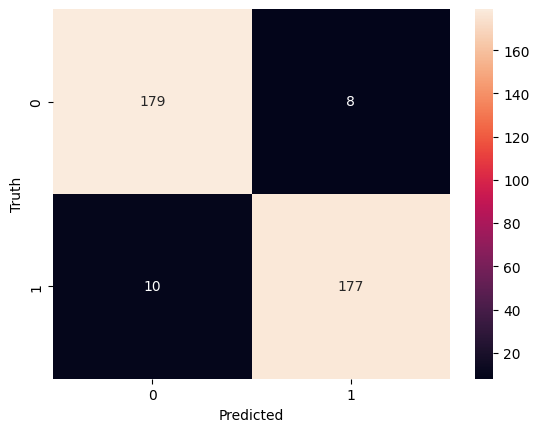

In [56]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel("Truth")

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       187
           1       0.96      0.95      0.95       187

    accuracy                           0.95       374
   macro avg       0.95      0.95      0.95       374
weighted avg       0.95      0.95      0.95       374



In [59]:
reviews=[
    'Enter a chance to win $3000000, hurry up, offer valid until Septmber 31, 2023',
    'You are awarded a SiPix Digital Camera! call 09061221061 from Landline. from landline. Delivery within 28 days',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.85971576],
       [0.93036526],
       [0.8160269 ],
       [0.20926027],
       [0.07110585]], dtype=float32)